Ahmad Mustapha

Ali Sahili

Hassan Tarhini

Ademon

### Imports

In [ ]:
!pip install datasets

In [ ]:
!pip install faiss-cpu

In [96]:
from PIL import Image, ImageOps
import io
import torch
import faiss
from datasets import load_dataset, load_from_disk
from transformers import ViTImageProcessor,  ViTModel

import numpy as np
import pandas as pd

from plotnine import *
%matplotlib inline
import matplotlib.offsetbox as offsetbox
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('agg')

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram

<ipython-input-96-5981e9919e30>:16: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.


### Dataset


In [ ]:
# Load the dataset from hugging face

In [ ]:
chartqa = load_dataset("ahmed-masry/ChartQA")
chartqa = chartqa["train"]

In [ ]:
# Dataset features

In [ ]:
chartqa.features

{'imgname': Value(dtype='string', id=None),
 'query': Value(dtype='string', id=None),
 'label': Value(dtype='string', id=None),
 'type': Value(dtype='string', id=None),
 'image': Value(dtype='binary', id=None)}

In [ ]:
# Dataset sample

In [57]:
sample = chartqa[1]
del sample["image"]
sample

{'imgname': '10095.png',
 'query': 'How many values are below 40 in Unfavorable graph?',
 'label': '6',
 'type': 'human'}

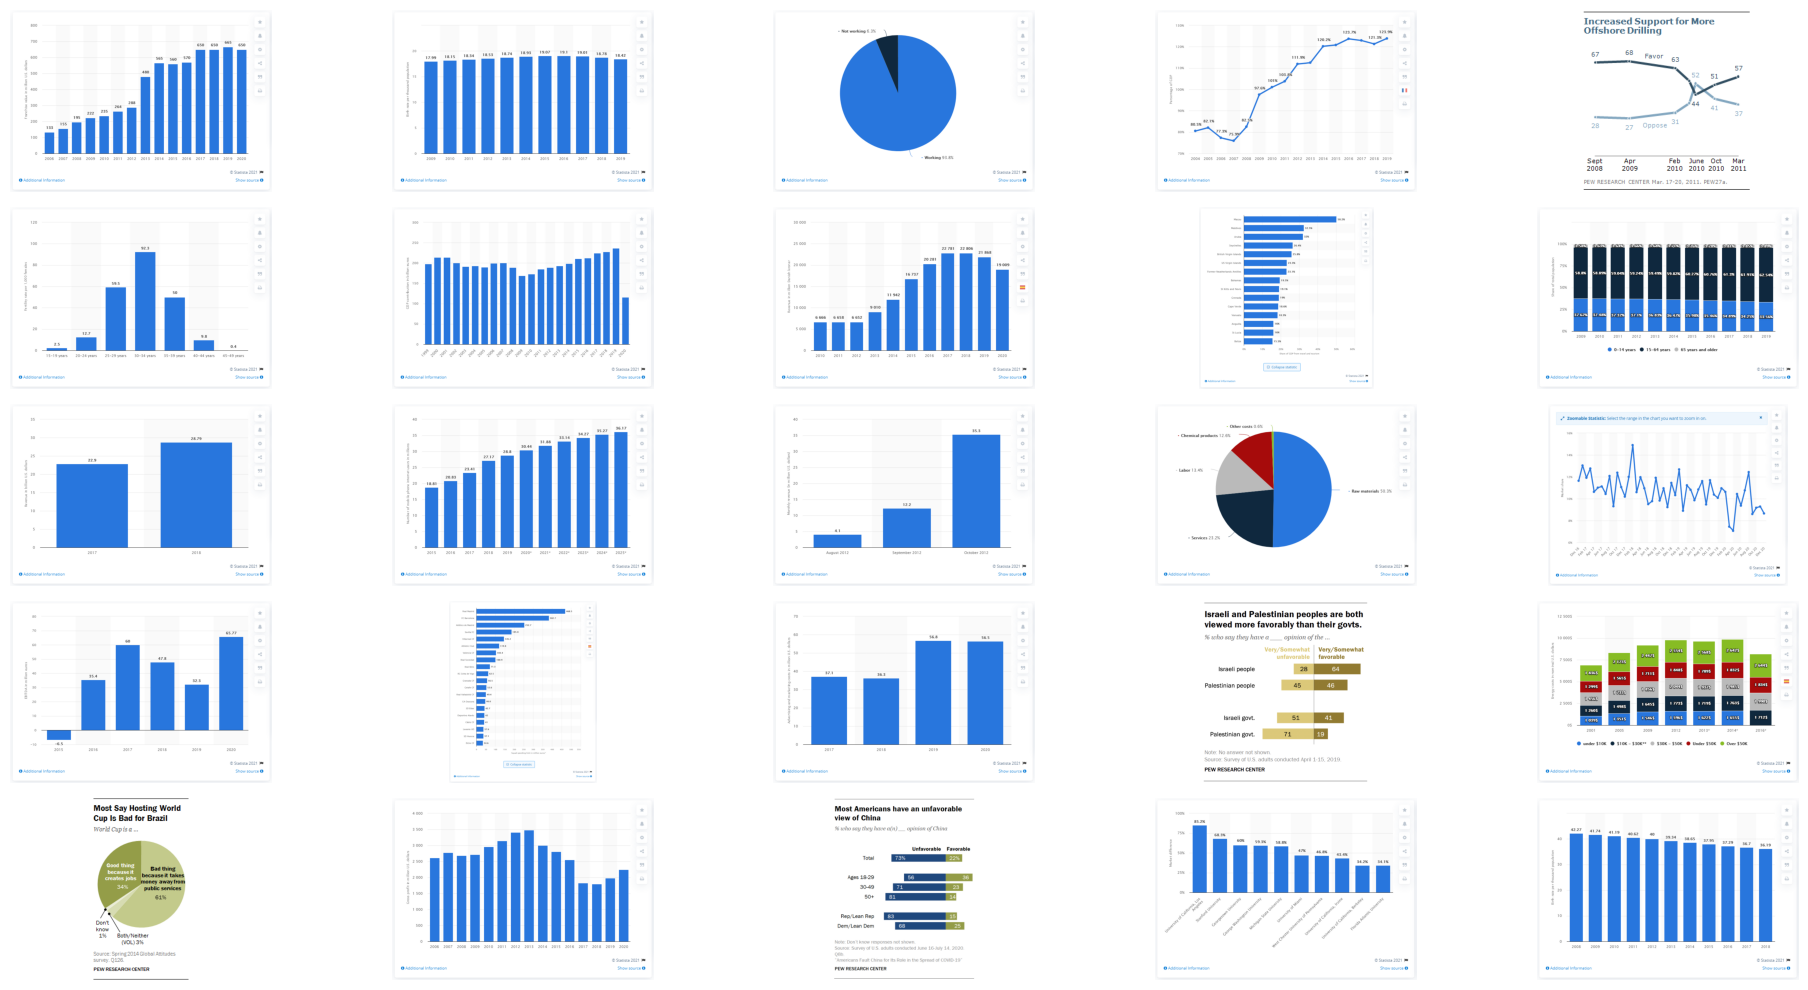

In [64]:
# Plot a sample of images

def get_image(byte_string):
  image = Image.open(io.BytesIO(byte_string)).convert("RGB")
  return image

random_indices = np.random.choice(len(chartqa), size=25, replace=False)
images = [get_image(image) for image in chartqa[random_indices]["image"]]

fig = plt.figure(figsize=(20, 10))
for i, image in enumerate(images):
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.axis('off')

fig.tight_layout()
fig

### Generate Visual Features


In [ ]:
# Get the visual features (vector of size 768) of each chart

In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:
model_identifier = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_identifier)
model = ViTModel.from_pretrained(model_identifier, device_map="auto")

In [ ]:
def extract_features(images, processor, model):
    inputs = processor(images=images, return_tensors="pt")
    inputs = inputs.to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    features = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return features

def get_embeddings(item):
  image = get_image(item["image"])
  item["embeddings"] = extract_features(image, processor, model)
  return item

embeddings = chartqa.map(get_embeddings, batched=False)

In [ ]:
# Keep important features

In [66]:
embeddings = embeddings.remove_columns(["imgname", "query", "label", "type"])

In [67]:
embeddings.features

{'image': Value(dtype='binary', id=None),
 'embeddings': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)}

In [ ]:
# Save new dataset to disk as it takes alot of time to get the features (around 15 minutes)

In [ ]:
embeddings.save_to_disk("...")

### Load Visual Features

In [ ]:
# Load the dataset that containes only images and their visual features

In [ ]:
chartqa = load_from_disk("...")

### Agglomerative Clustering

In [ ]:
# Extract visual features as X

In [71]:
visual_features = np.array(chartqa["embeddings"])

In [73]:
visual_features.shape

(28299, 768)

In [75]:
X = visual_features

In [ ]:
# Preprocess X

In [76]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_normalized = normalize(X_scaled)

In [ ]:
# Reduce X dimensionality

In [86]:
pca = PCA(n_components = 30)
X_principal = pca.fit_transform(X_normalized)

In [87]:
X_principal.shape

(28299, 30)

In [ ]:
# Apply hierarchical clustering using the ward linkage (takes 1 minute)

In [89]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', linkage='ward')
model = model.fit(X_principal)

In [98]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return dendrogram(linkage_matrix, **kwargs)

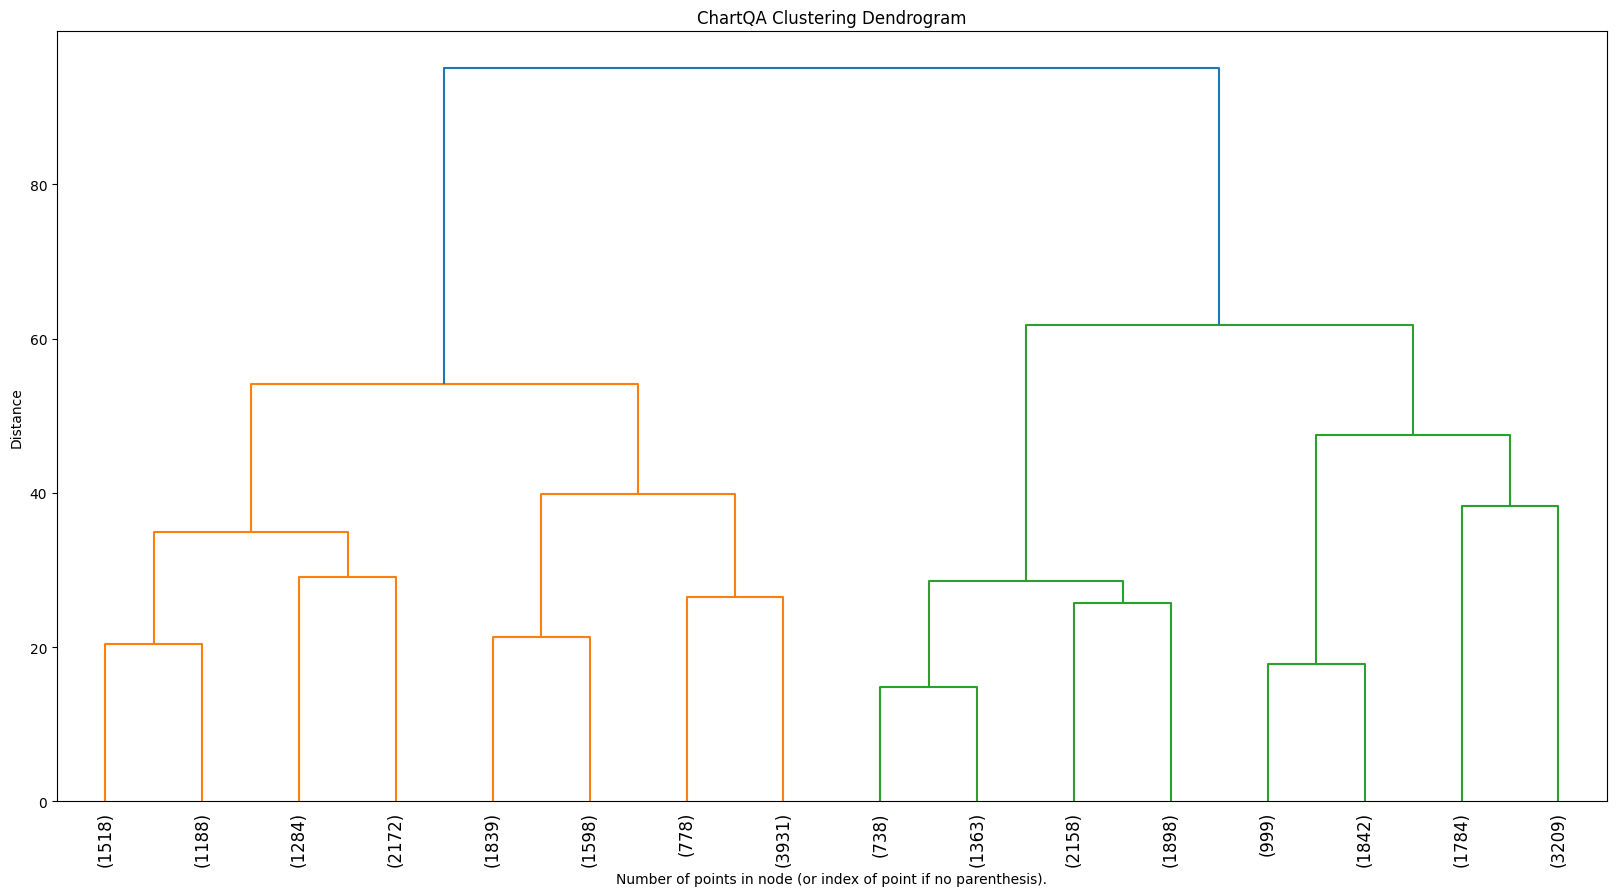

In [105]:
fig = plt.figure(figsize=(20, 10))
plt.title("ChartQA Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('Distance')
plot_dendrogram(model, truncate_mode="level", p=3, leaf_rotation=90)
fig

In [ ]:
# Extarct the labels of each cluster

In [120]:
n_labels = 16
model = AgglomerativeClustering(n_clusters=n_labels, metric='euclidean', linkage='ward')
model = model.fit(X_principal)

In [ ]:
labels = model.labels_

In [125]:
images = chartqa["image"]
for i in range(n_labels):
  fig = plt.figure(figsize=(20, 10))
  label_indices = np.where(labels == i)[0]
  random_indices = np.random.choice(label_indices, size=25, replace=False)
  images = [get_image(image) for image in chartqa[random_indices]["image"]]
  plt.title(f"Cluster {i}")
  plt.axis('off')
  for j, image in enumerate(images):
    plt.subplot(5, 5, j+1)
    plt.imshow(image)
    plt.axis('off')
  plt.savefig(f"cluster_{i}.png")

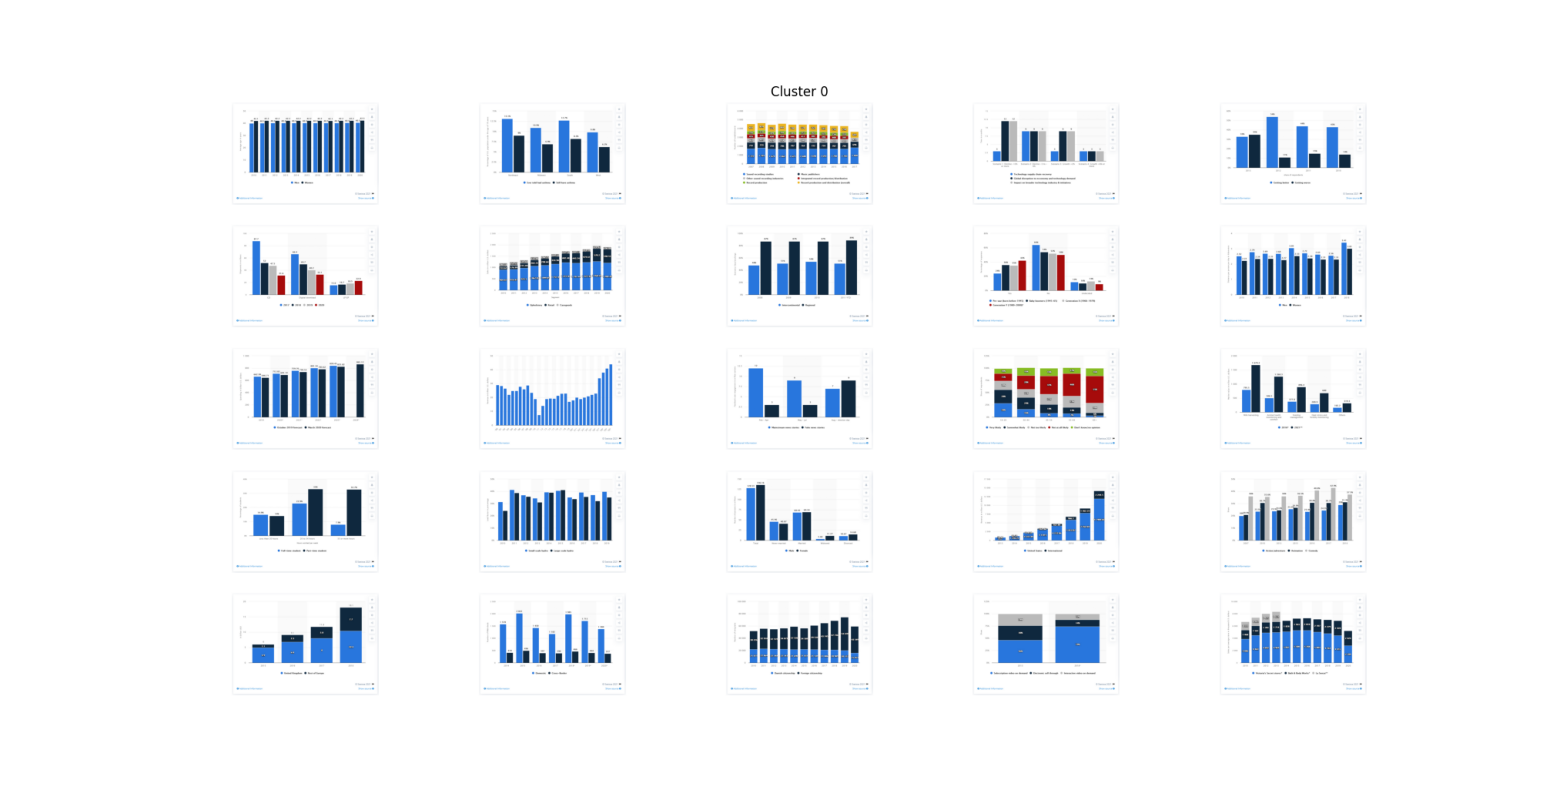

In [129]:
img = plt.imread('/content/cluster_0.png')
fig = plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
fig

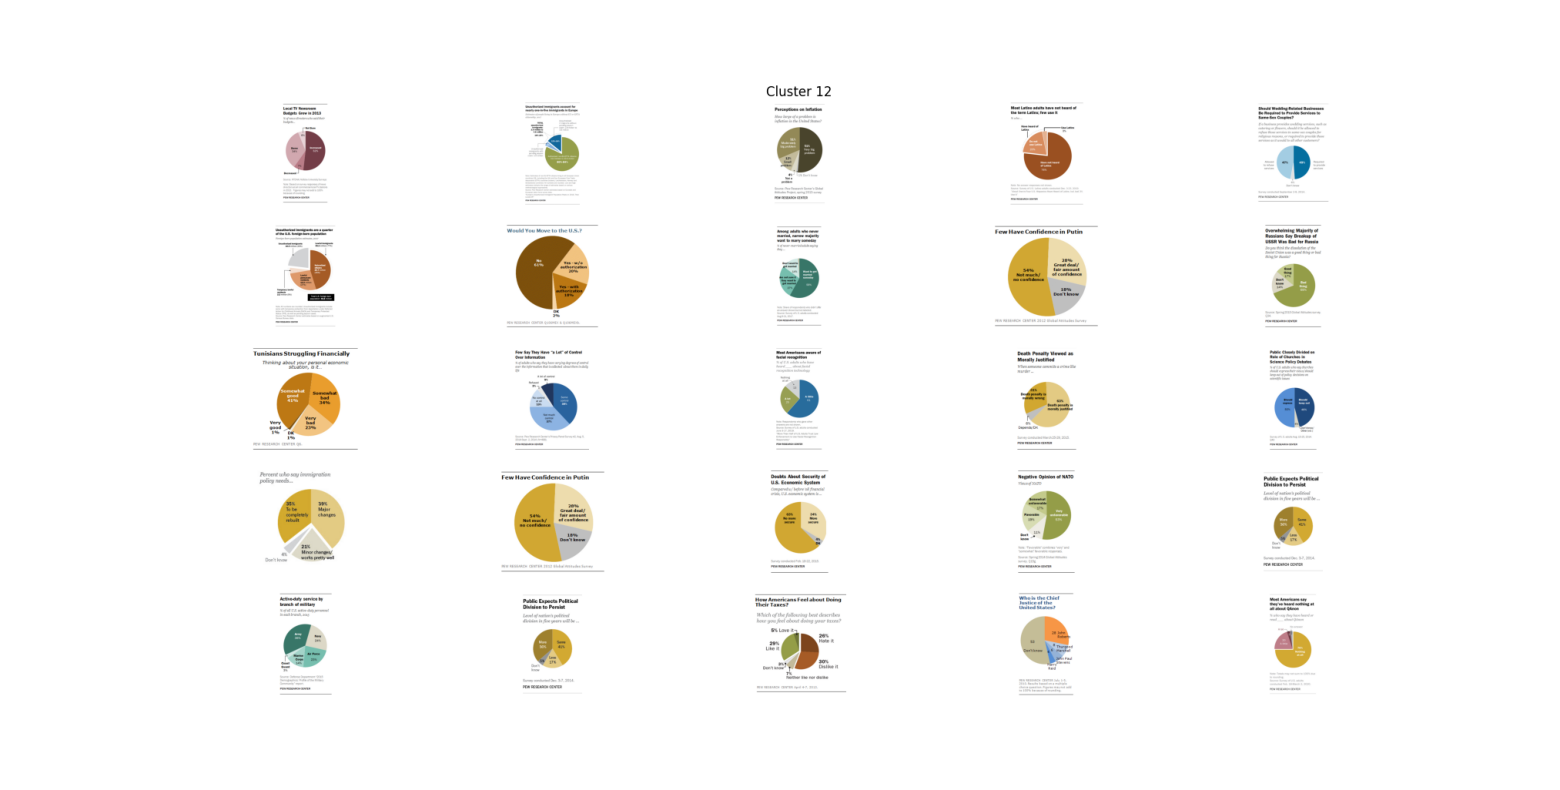

In [130]:
img = plt.imread('/content/cluster_12.png')
fig = plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
fig

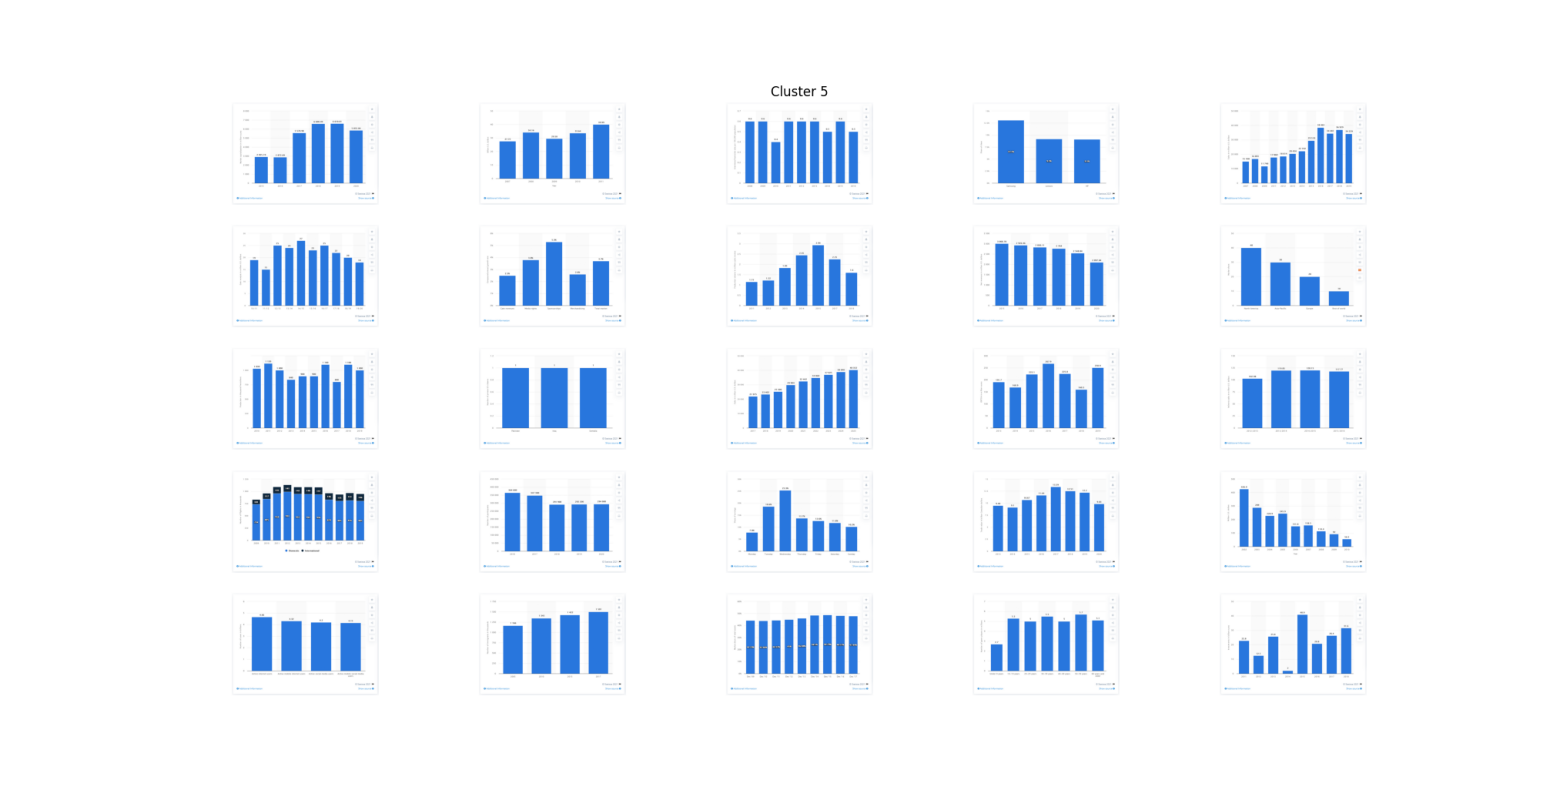

In [131]:
img = plt.imread('/content/cluster_5.png')
fig = plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
fig

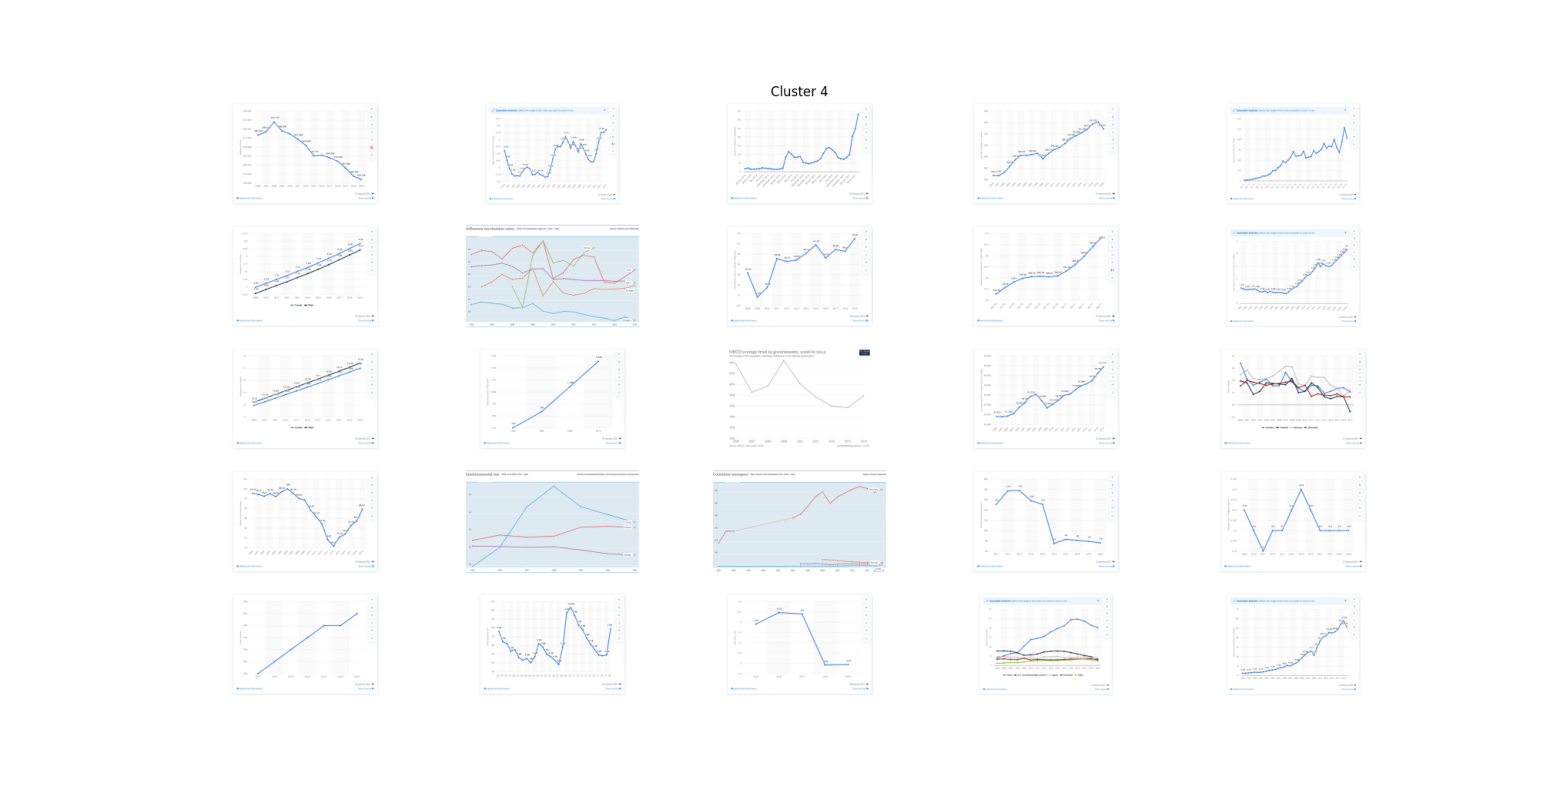

In [132]:
img = plt.imread('/content/cluster_4.png')
fig = plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
fig

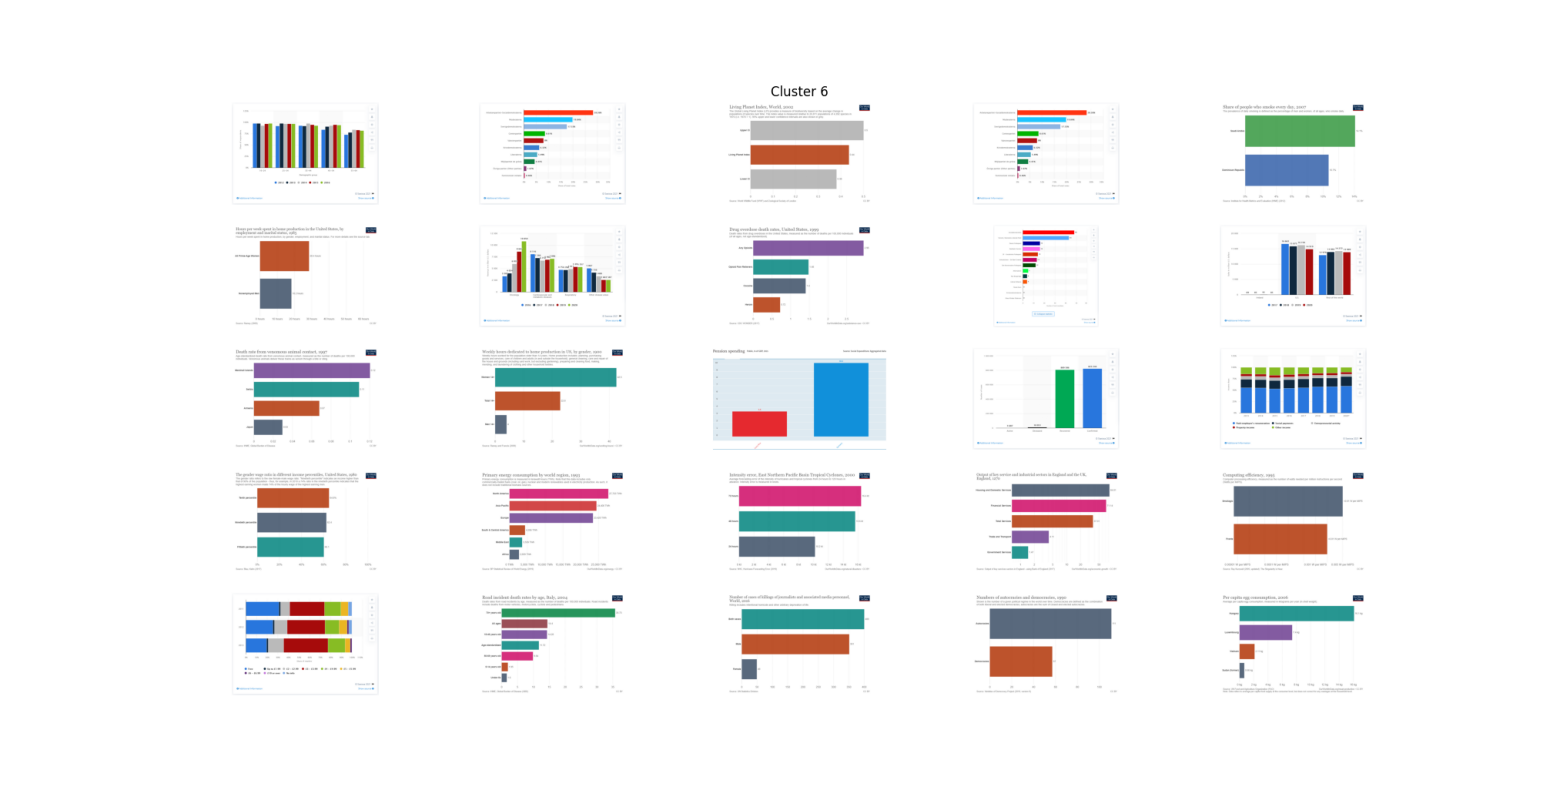

In [133]:
img = plt.imread('/content/cluster_6.png')
fig = plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
fig